# BTC-USD @24h

In [26]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'sp500',
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}
# OUT_FILENAME = './results/'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [3]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [5]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> BTC-USD: 1324 data points
  from 2015-02-28 00:00:00 to 2018-10-13 00:00:00


close   open   high    low  volume  missing
datetime                                               
2015-02-28  253.0  253.1  254.3  245.2    3.61        0

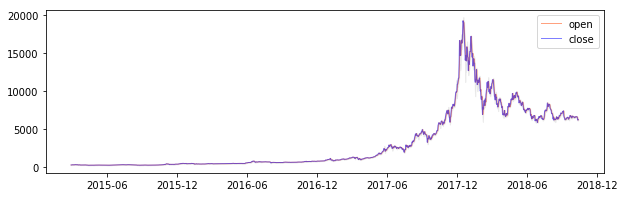

In [24]:
data_btc = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
data_btc = data_btc[data_btc.index >= '2015-02-28']
print("> BTC-USD: %d data points" % (len(data_btc),))
print("  from %s to %s" % (data_btc.iloc[0].name, data_btc.iloc[-1].name))
simple_plot(data_btc, show_xlabels=False)
dd(data_btc.head(1))



---------
> stock OSTK: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high    low  missing  weekday
datetime                                                        
2015-03-02  23.86  177195.0  22.7  23.9  22.52      0.0        0

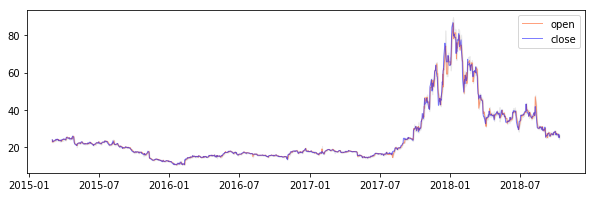



---------
> stock RIOT: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high   low  missing  weekday
datetime                                                       
2015-03-02   4.44  158462.0   4.4  4.88  4.32      0.0        0

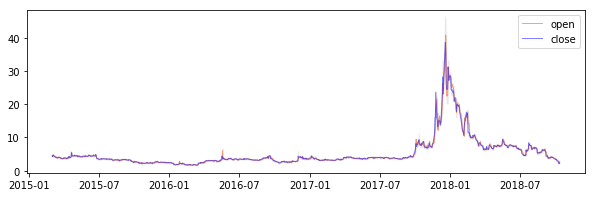



---------
> stock AMD: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close      volume  open  high   low  missing  weekday
datetime                                                         
2015-03-02   3.21  15629320.0  3.13  3.23  3.11      0.0        0

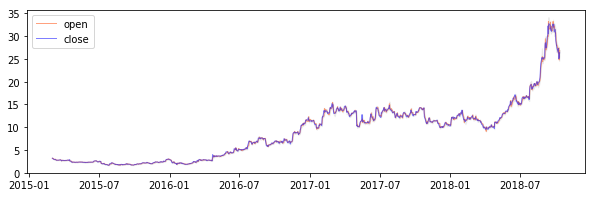



---------
> stock GBTC: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close  volume    open    high     low  missing  weekday
datetime                                                            
2015-03-02  0.2088     0.0  0.2088  0.2088  0.2088      0.0        0

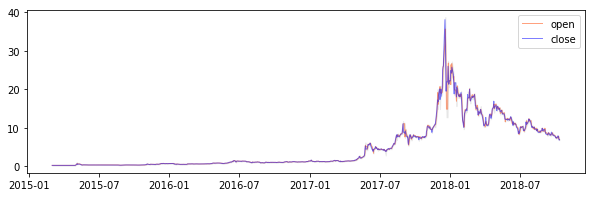



---------
> stock NVDA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume  open   high     low  missing  weekday
datetime                                                            
2015-03-02  22.595  7536531.0  22.0  22.72  21.971      0.0        0

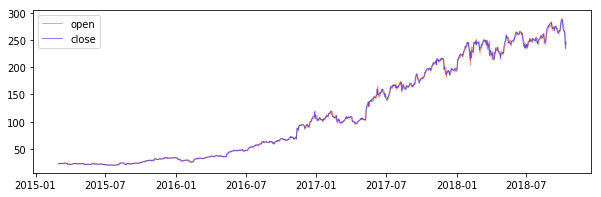



---------
> stock SIEB: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close  volume  open  high   low  missing  weekday
datetime                                                     
2015-03-02   1.68  4320.0  1.62  1.68  1.61      0.0        0

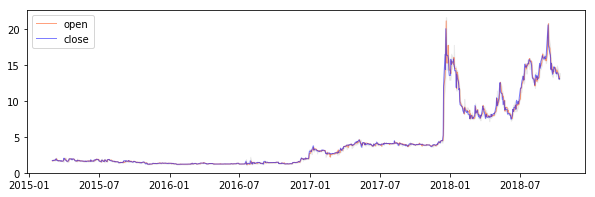



---------
> stock OTIV: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high   low  missing  weekday
datetime                                                       
2015-03-02   1.32  153286.0  1.25  1.33  1.25      0.0        0

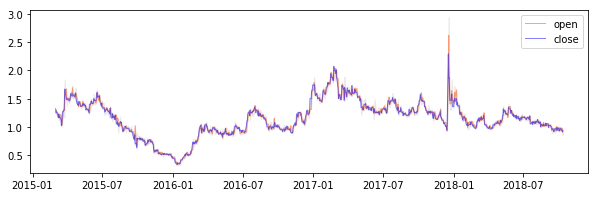



---------
> stock SP500: 914 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     open     high     low  volume  missing  weekday
datetime                                                               
2015-03-02  2117.39  2105.23  2117.52  2104.5     NaN        0        0

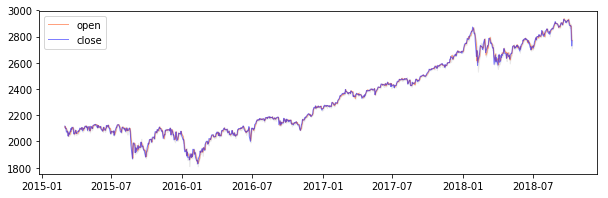



---------
> stock MARA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume   open    high    low  missing  weekday
datetime                                                          
2015-03-02  29.88  40587.0  29.76  30.576  29.28      0.0        0

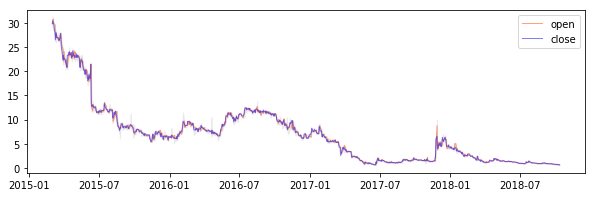

In [27]:
stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    stocks_data[stock] = data
    print("\n\n---------")
    print("> stock %s: %d data points" % (stock.upper(), len(data)))
    print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
    dd(data.head(1))
    simple_plot(data, show_xlabels=False)
    plt.show()

## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs. More consistency at 10 but average quality drops.



        #################################
        # ostk
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140693375196752
Tensor("lstm_1_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              252       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 

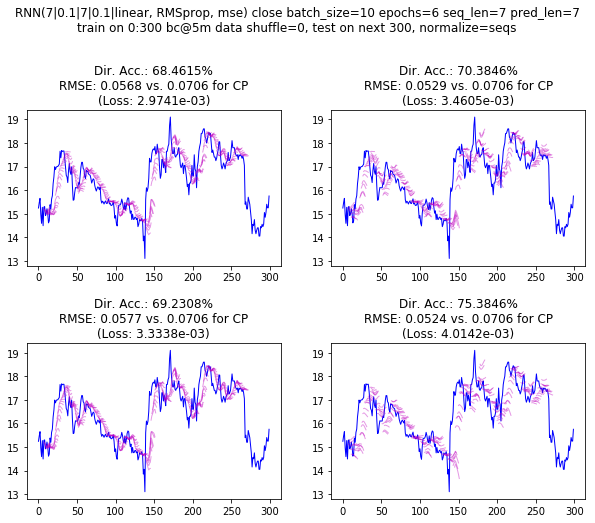

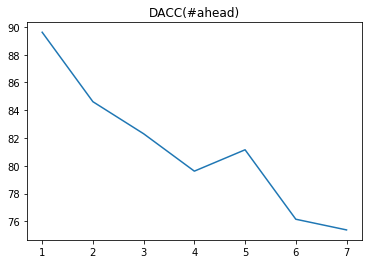

--- 19.964s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140692374143824
Tensor("lstm_9_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 7)              252       
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)           

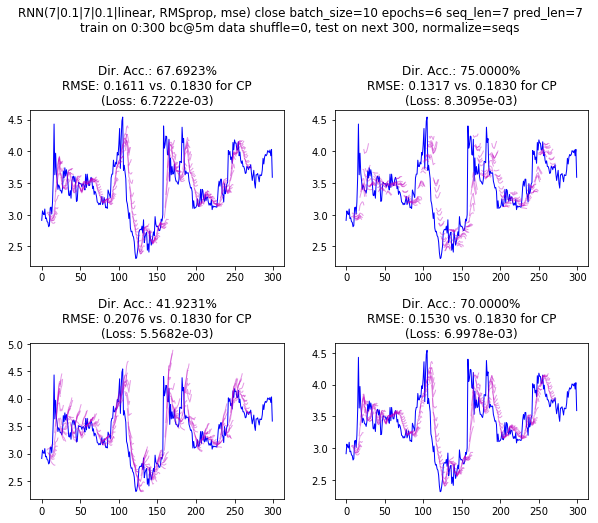

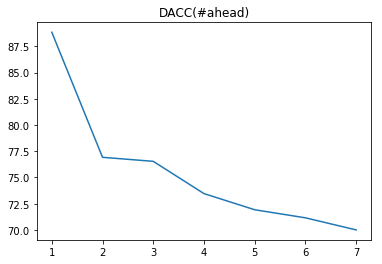

--- 21.545s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140692074924624
Tensor("lstm_17_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_18 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)           

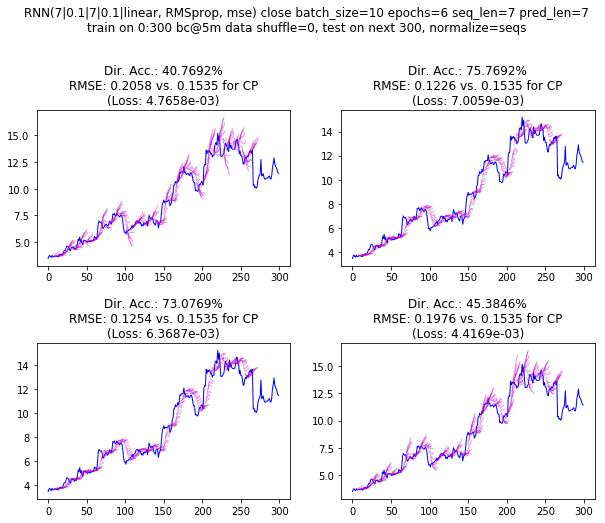

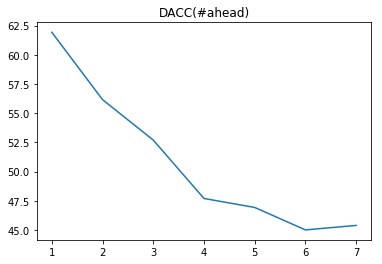

--- 28.332s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140691931118480
Tensor("lstm_25_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)          

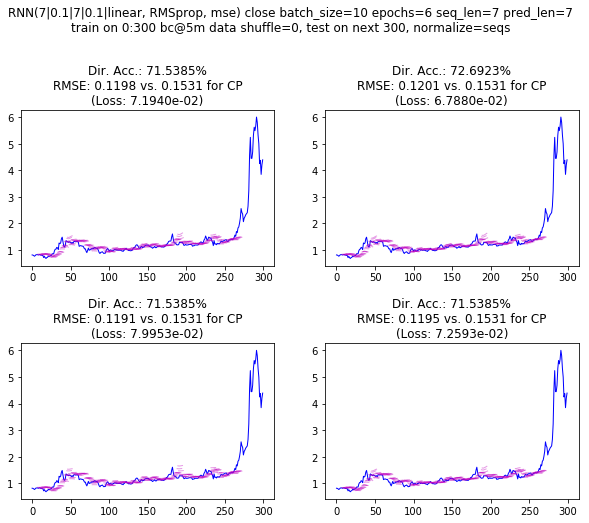

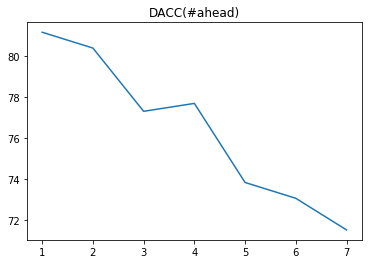

--- 28.614s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140691523029520
Tensor("lstm_33_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)          

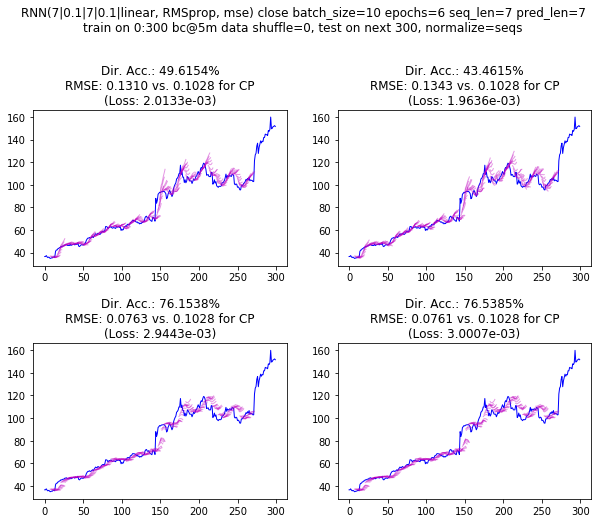

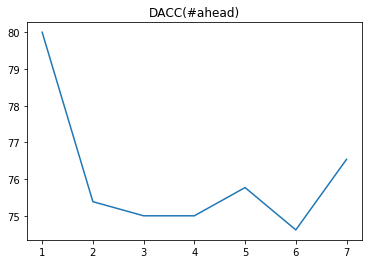

--- 35.372s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 1)
--- 0.015s to model compilation time


--- Created model id: 140691453944656
Tensor("lstm_41_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_42 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)          

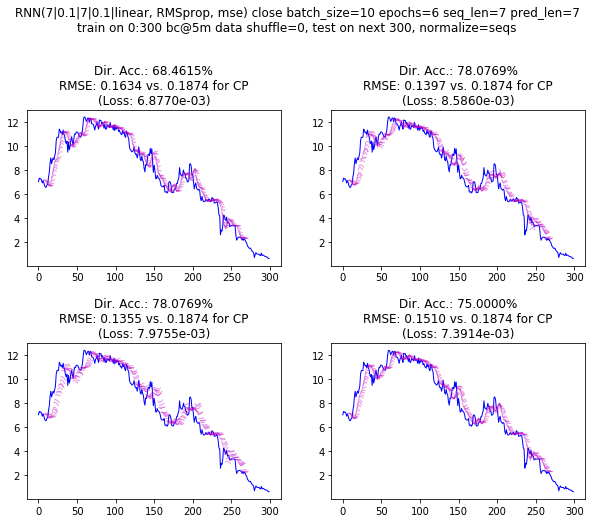

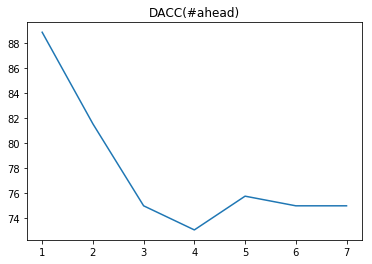

--- 41.258s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140691382069008
Tensor("lstm_49_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_50 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)          

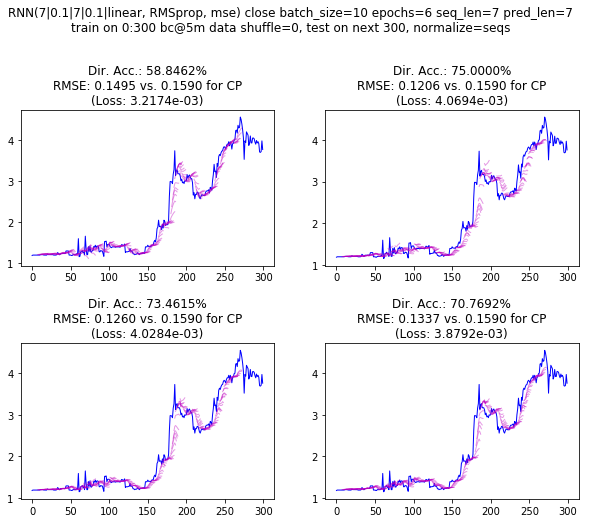

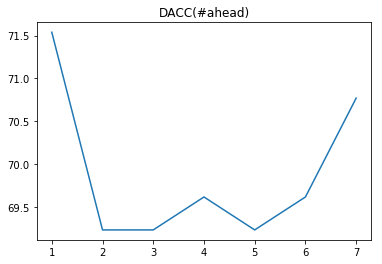

--- 44.256s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 1)
--- 0.015s to model compilation time


--- Created model id: 140691379760336
Tensor("lstm_57_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)         

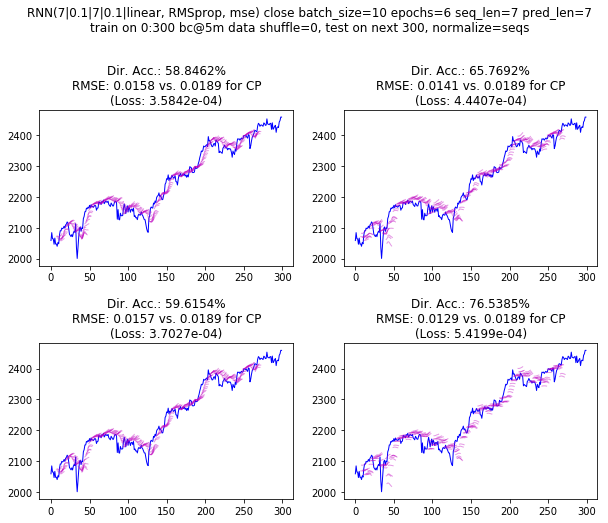

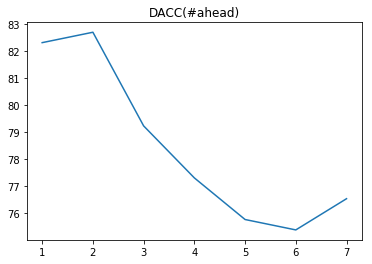

--- 44.825s to run experiment



        #################################
        # otiv
        #################################
        
data ~ (600, 1)
--- 0.015s to model compilation time


--- Created model id: 140691224706384
Tensor("lstm_65_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_65 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_66 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)          

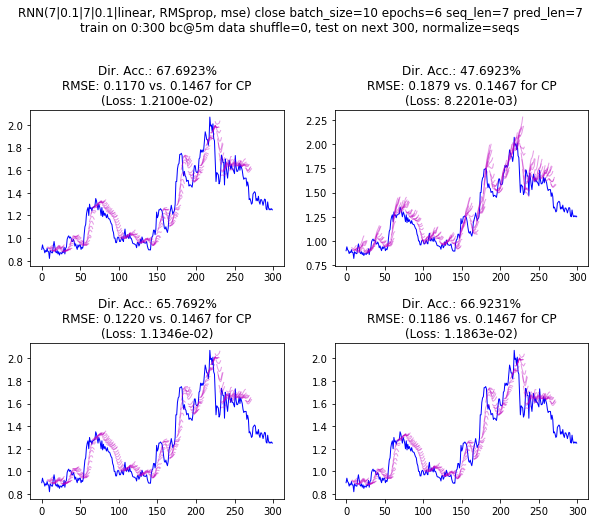

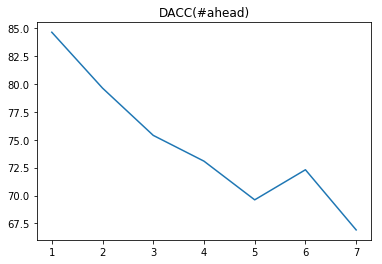

--- 52.855s to run experiment



In [29]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140691154242384
Tensor("lstm_75_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_75 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_76 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 8         
Total params:

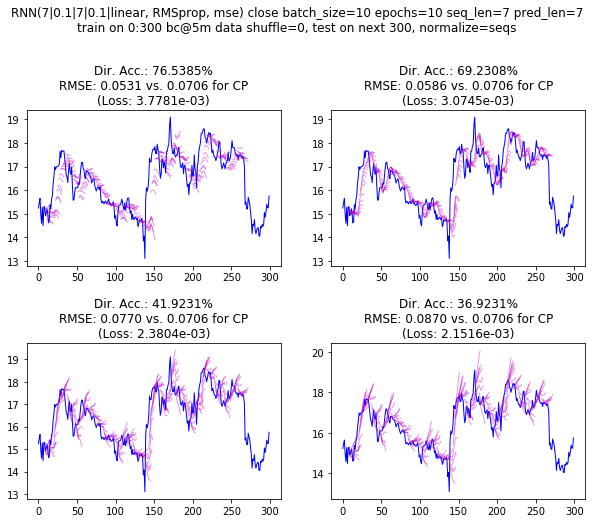

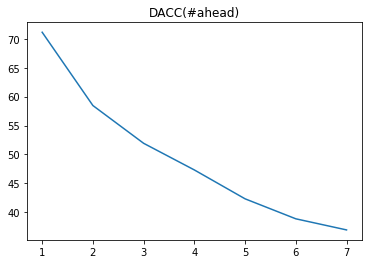

--- 59.175s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140691204893072
Tensor("lstm_83_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_83 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_84 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)          

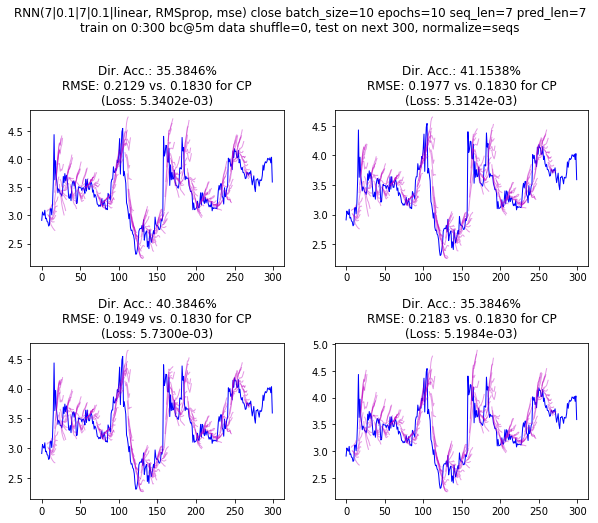

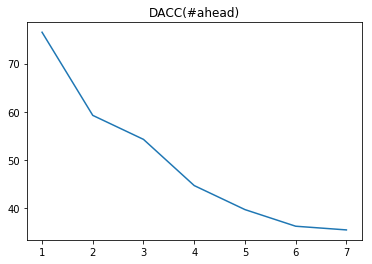

--- 62.399s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 1)
--- 0.015s to model compilation time


--- Created model id: 140691201754640
Tensor("lstm_91_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_91 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_92 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)           

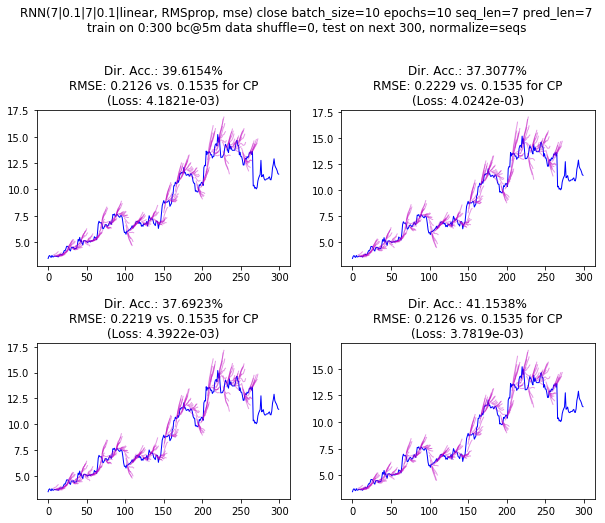

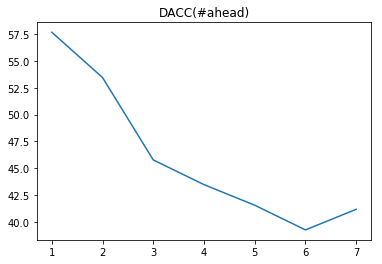

--- 65.291s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140690911193936
Tensor("lstm_99_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_99 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_100 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)          

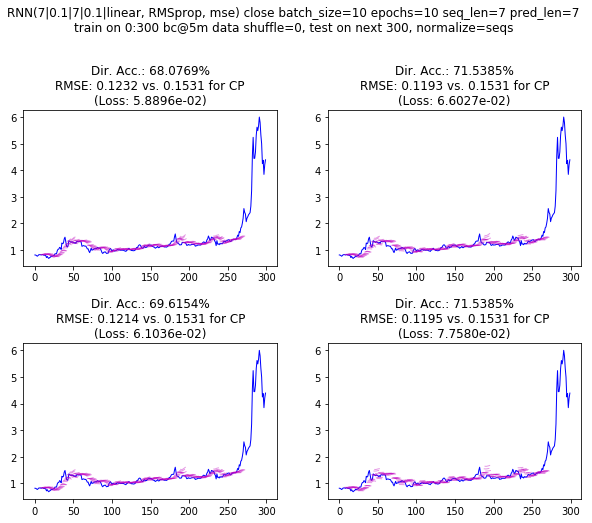

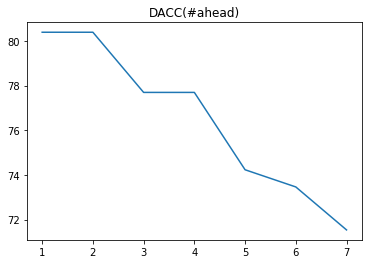

--- 73.603s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140690878169936
Tensor("lstm_107_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_107 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_107 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_108 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_108 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)         

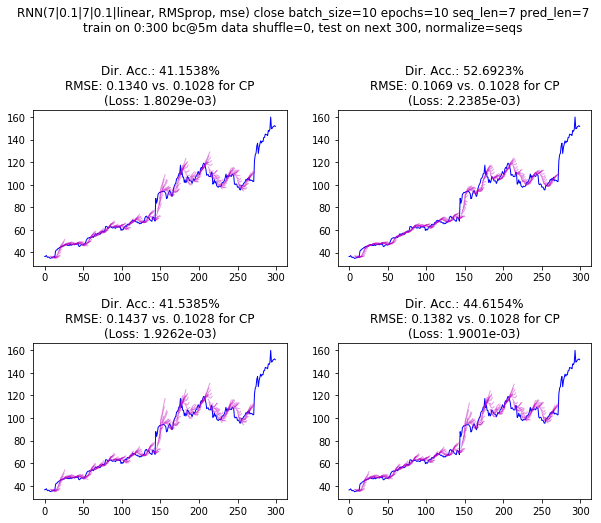

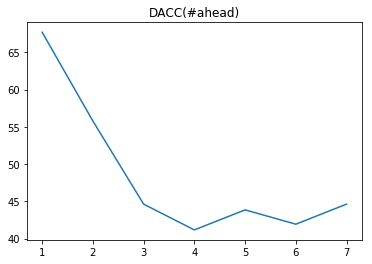

--- 73.642s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140690789061392
Tensor("lstm_115_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_115 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_116 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_116 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)         

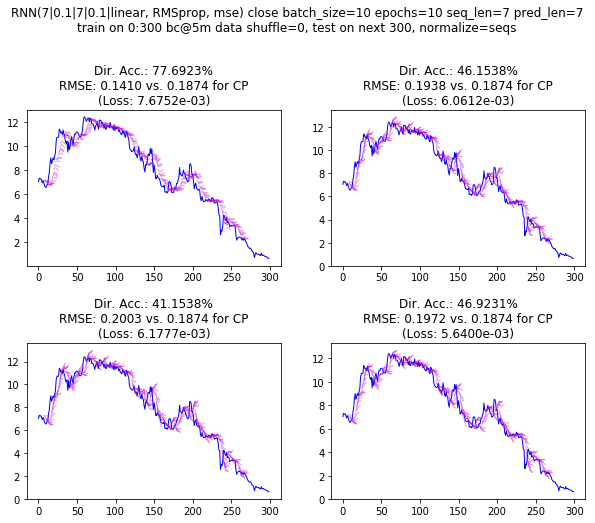

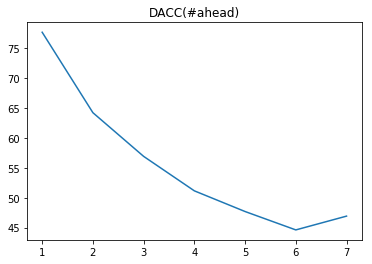

--- 83.475s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 1)
--- 0.029s to model compilation time


--- Created model id: 140690795758544
Tensor("lstm_123_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_123 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_124 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_124 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)         

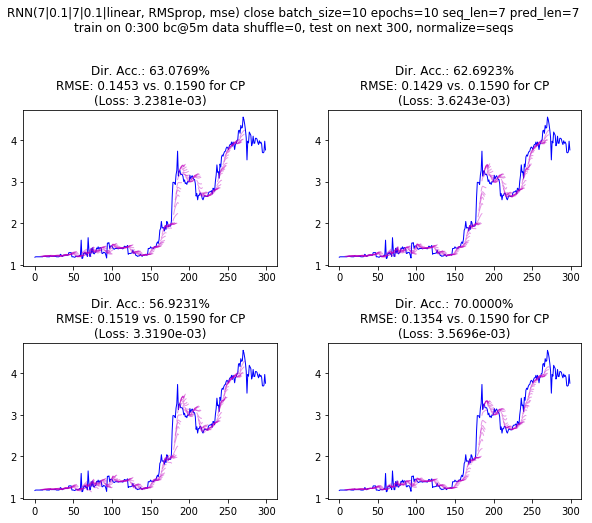

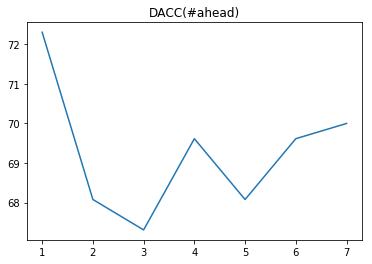

--- 81.975s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140690649227664
Tensor("lstm_131_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_131 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_132 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)        

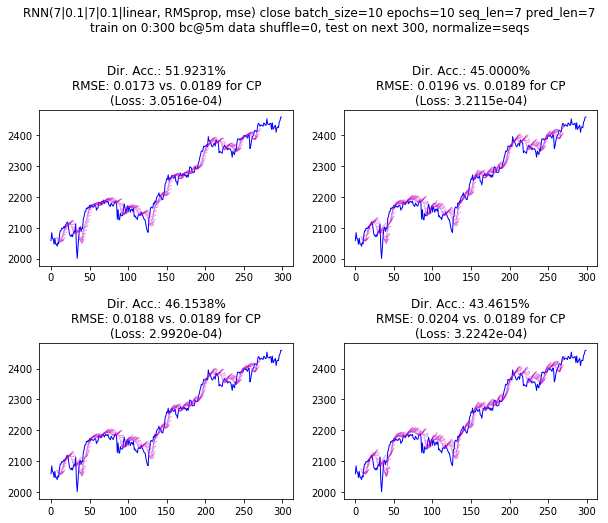

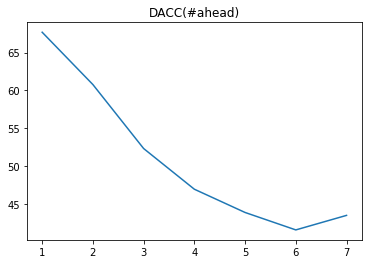

--- 87.350s to run experiment



        #################################
        # otiv
        #################################
        
data ~ (600, 1)
--- 0.031s to model compilation time


--- Created model id: 140690561203280
Tensor("lstm_139_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_139 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_140 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_140 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)         

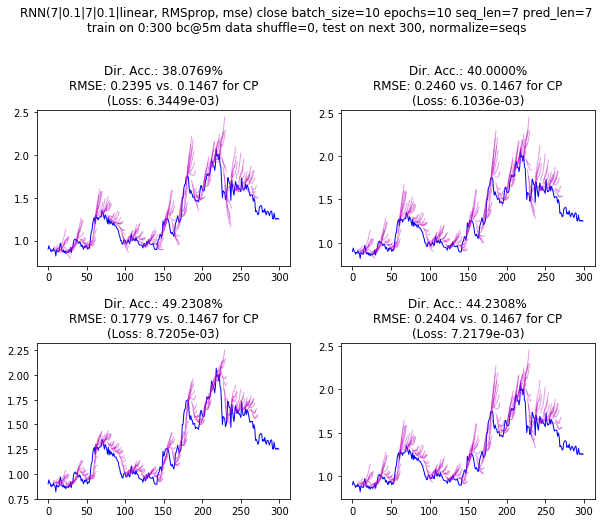

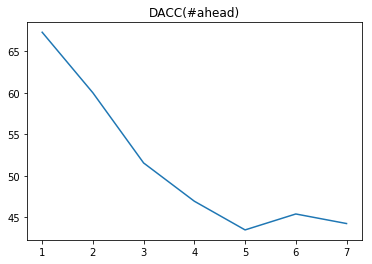

--- 96.104s to run experiment



In [31]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
            run_walk_forward_validation_rnn(
                # data to extract:
                data,
                features=['close'],
                from_i=0,
                train_sz=300,
                test_sz=300,
                # data processing:
                normalize='seqs',  # 'seqs' | 'data'
                detrend=False,
                # model and prediction arrangement:
                seq_len=7,
                pred_len=7,
                model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
                # training:
                epochs=10,
                batch_size=10,
                shuffle=False,
                # experiment setup:
                times=4,
                skip=False,
                fix_all_rngs_to=False,
                fix_rngs_before_each=False,
                # plotting:
                fig_size=(10, 8),
                fast=True,
            )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.



        #################################
        # ostk
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140690473802256
Tensor("lstm_147_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_147 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_148 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_148 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 4         
Total params

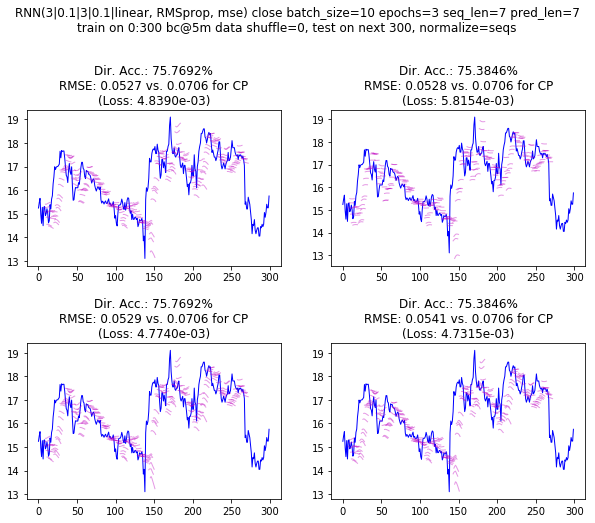

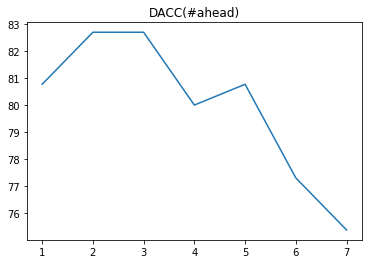

--- 90.771s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 1)
--- 0.024s to model compilation time


--- Created model id: 140690455612240
Tensor("lstm_155_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_155 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_156 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)         

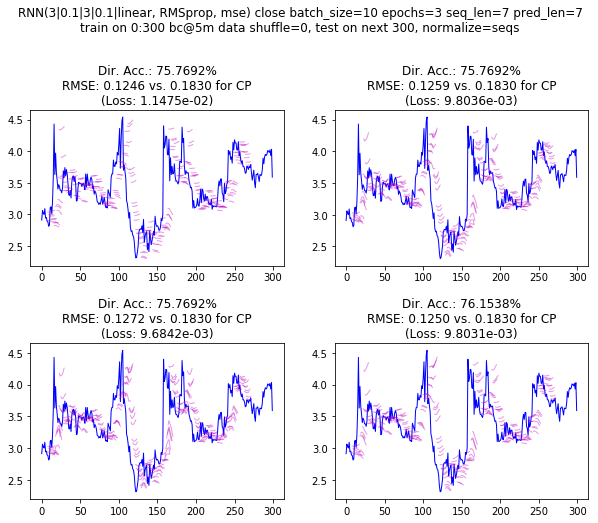

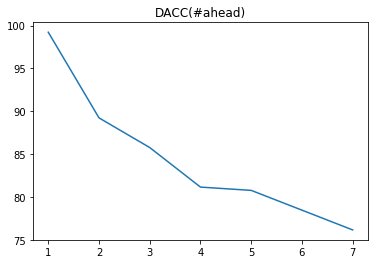

--- 95.069s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 1)
--- 0.027s to model compilation time


--- Created model id: 140690470629200
Tensor("lstm_163_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_163 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_163 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_164 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_164 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)          

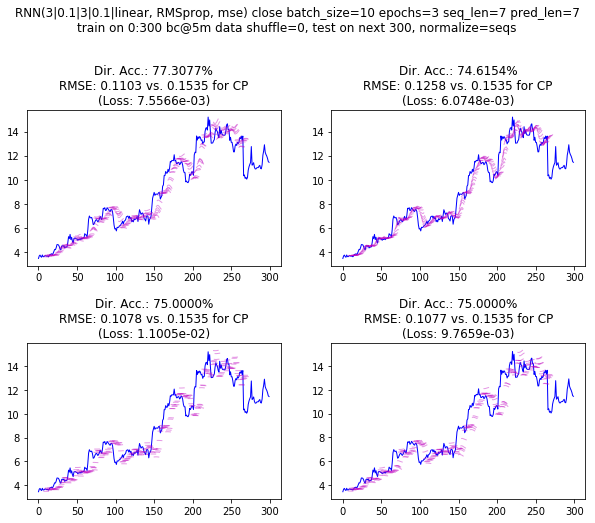

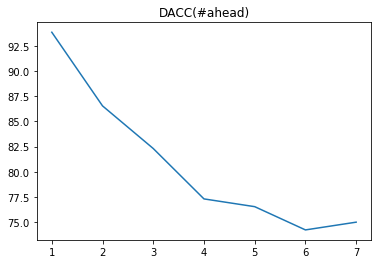

--- 98.094s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140690278247120
Tensor("lstm_171_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_171 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_171 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_172 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_172 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)         

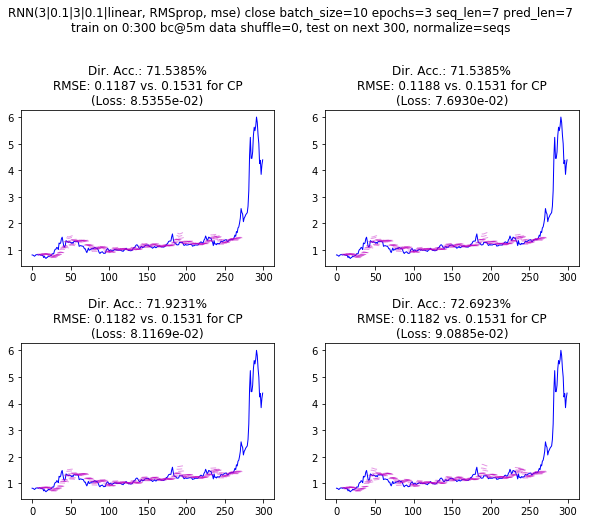

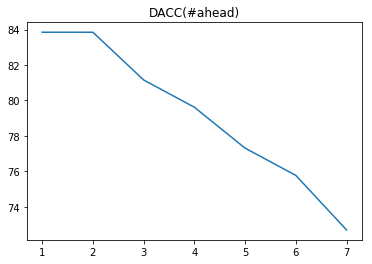

--- 104.319s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140690188124304
Tensor("lstm_179_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_179 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_180 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_180 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)        

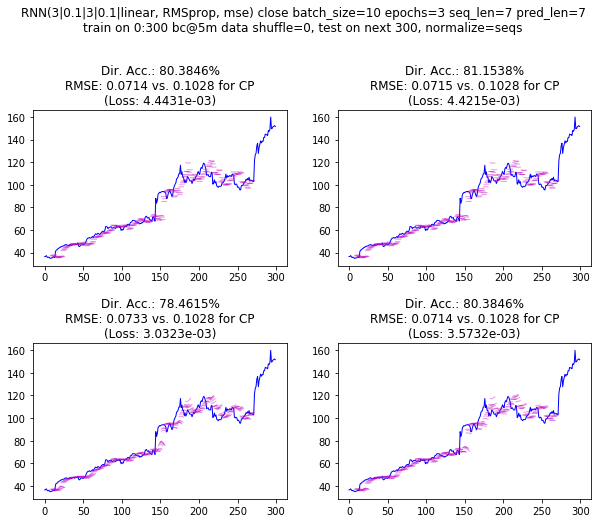

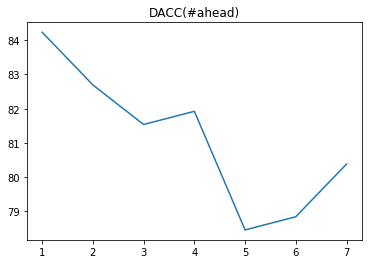

--- 106.038s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140690156572880
Tensor("lstm_187_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_187 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_188 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)        

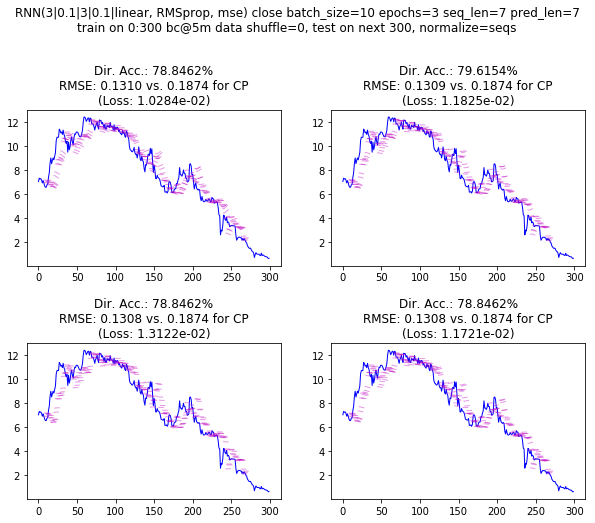

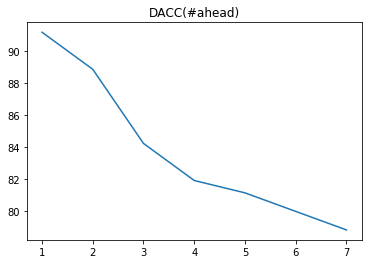

--- 111.056s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 1)
--- 0.032s to model compilation time


--- Created model id: 140690066760208
Tensor("lstm_195_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_195 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_195 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_196 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_196 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)        

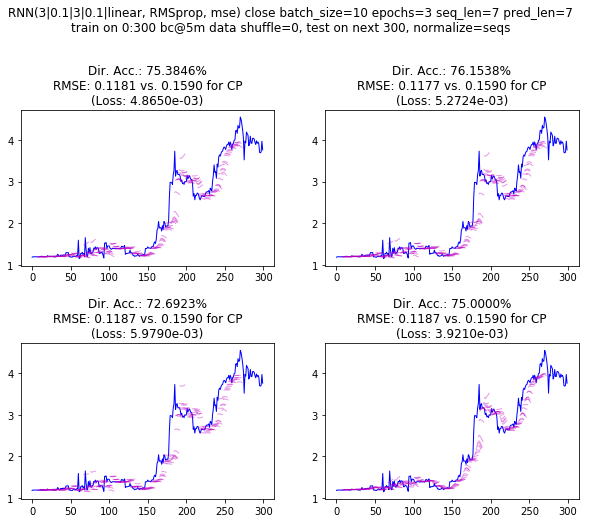

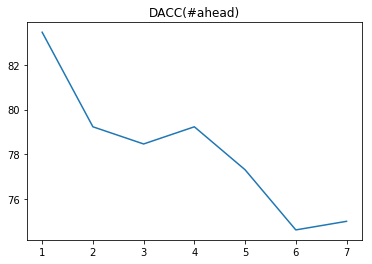

--- 123.291s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140689977527440
Tensor("lstm_203_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_203 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_203 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_204 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_204 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)       

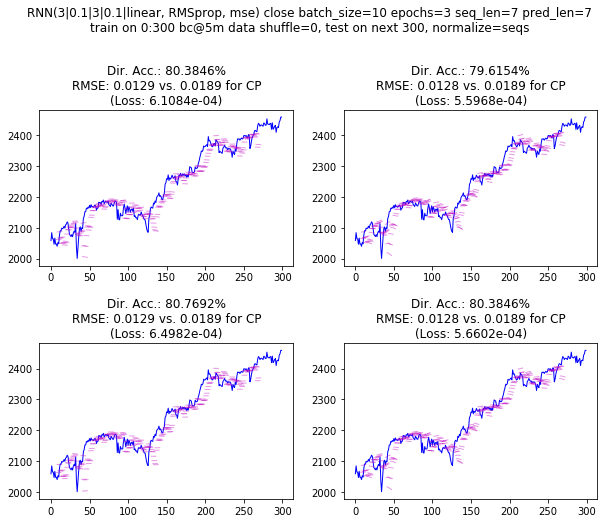

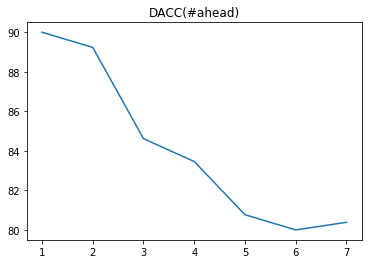

--- 118.964s to run experiment



        #################################
        # otiv
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140689891654928
Tensor("lstm_211_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_211 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_211 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_212 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_212 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 1)        

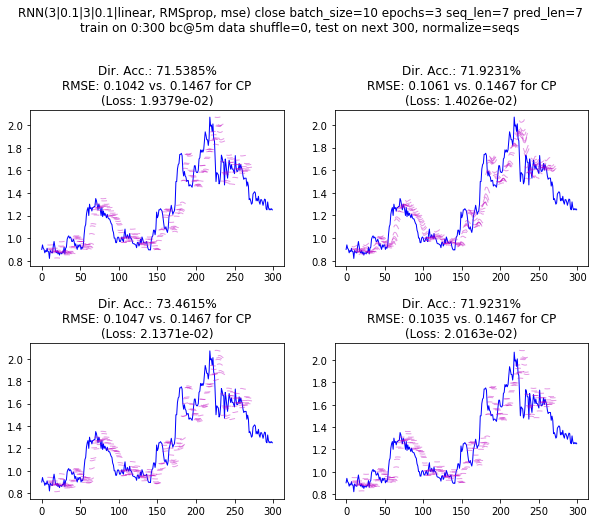

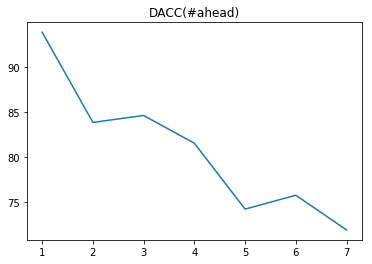

--- 127.275s to run experiment



In [32]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=3,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140690190445008
Tensor("lstm_219_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_219 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_219 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_220 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_220 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 4         
Total params

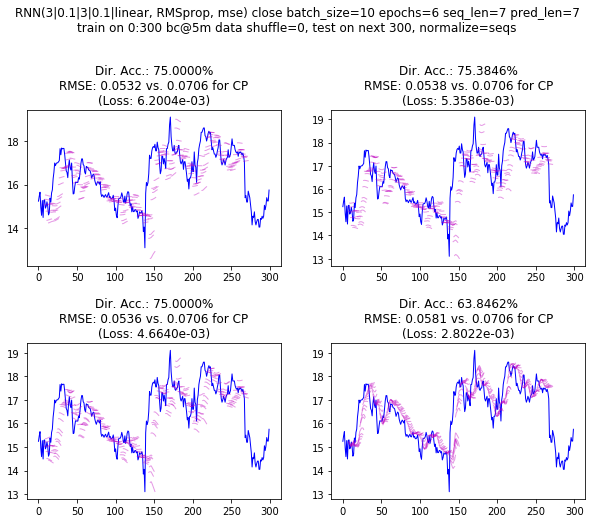

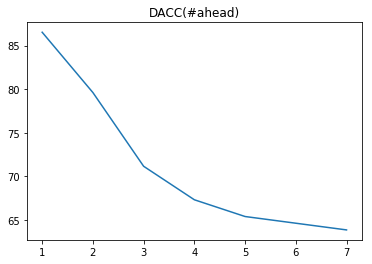

--- 137.354s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140689801474128
Tensor("lstm_227_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_227 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_227 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_228 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_228 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)        

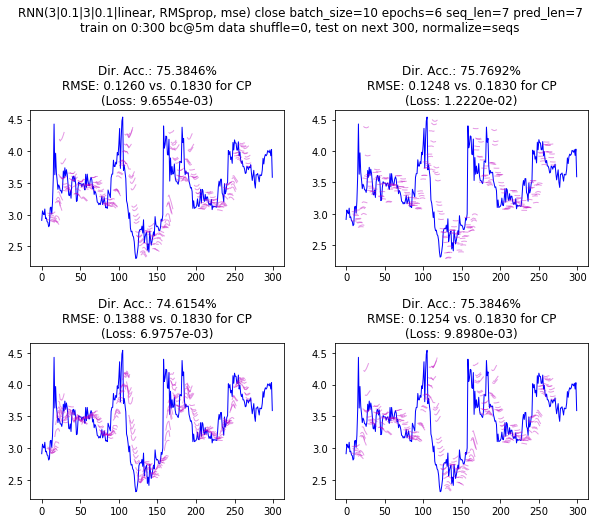

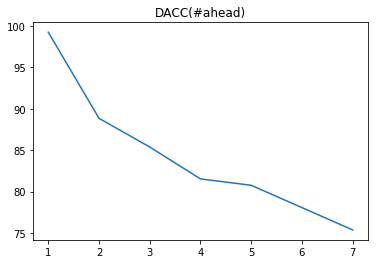

--- 135.443s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140689713146832
Tensor("lstm_235_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_235 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_235 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_236 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_236 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_118 (Dense)            (None, 1)         

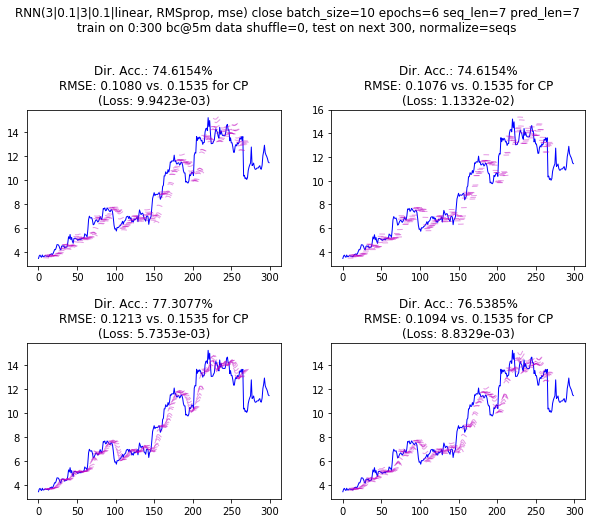

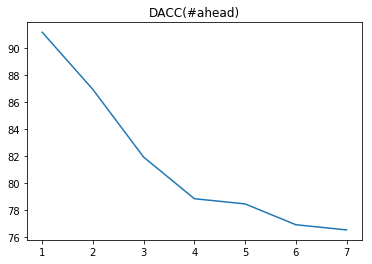

--- 148.045s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 1)
--- 0.022s to model compilation time


--- Created model id: 140689625837072
Tensor("lstm_243_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_243 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_243 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_244 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_244 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)        

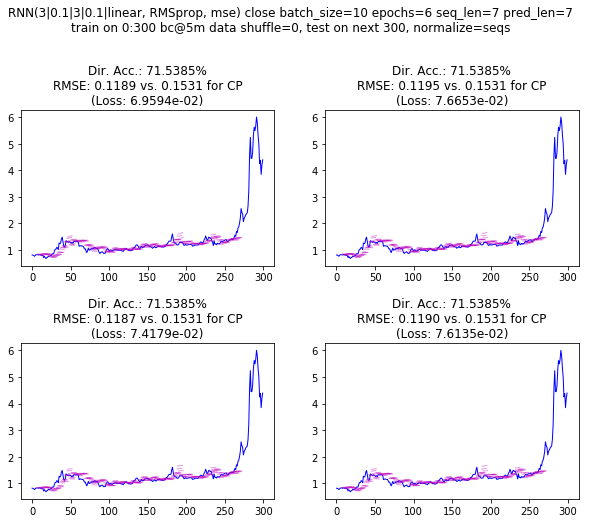

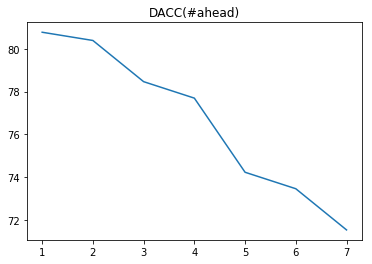

--- 157.679s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 1)
--- 0.035s to model compilation time


--- Created model id: 140689537531856
Tensor("lstm_251_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_251 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_251 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_252 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_252 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_126 (Dense)            (None, 1)        

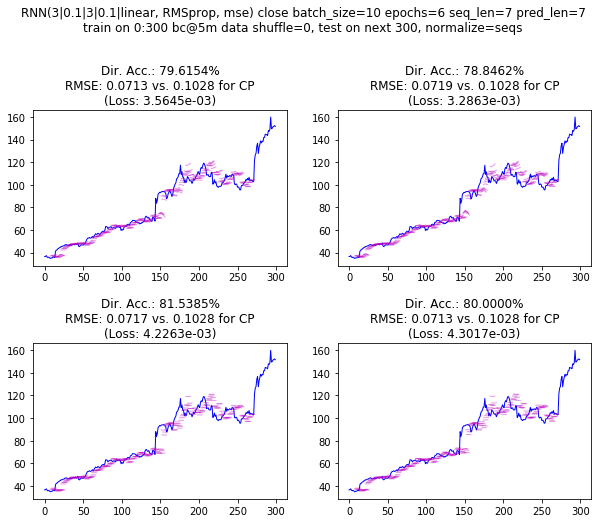

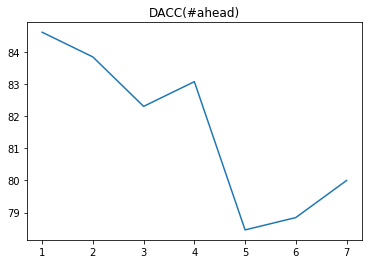

--- 163.316s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140689447661968
Tensor("lstm_259_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_259 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_259 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_260 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_260 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_130 (Dense)            (None, 1)        

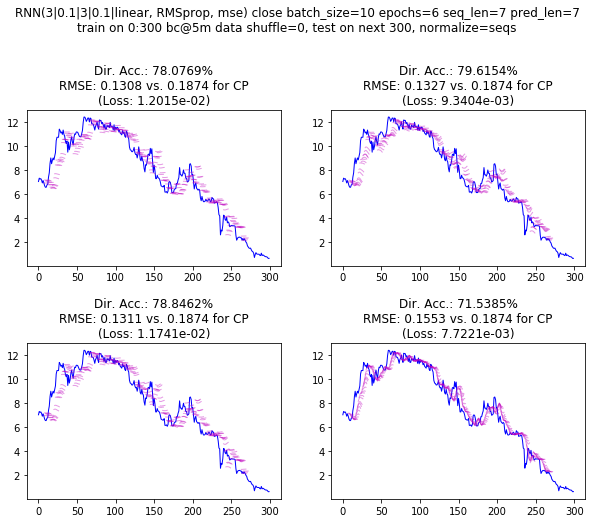

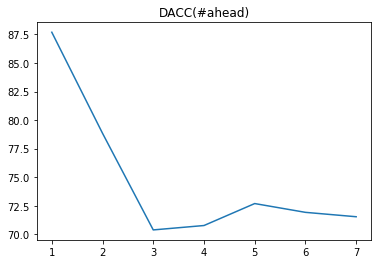

--- 233.830s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 1)
--- 0.024s to model compilation time


--- Created model id: 140689915257488
Tensor("lstm_267_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_267 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_267 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_268 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_268 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_134 (Dense)            (None, 1)        

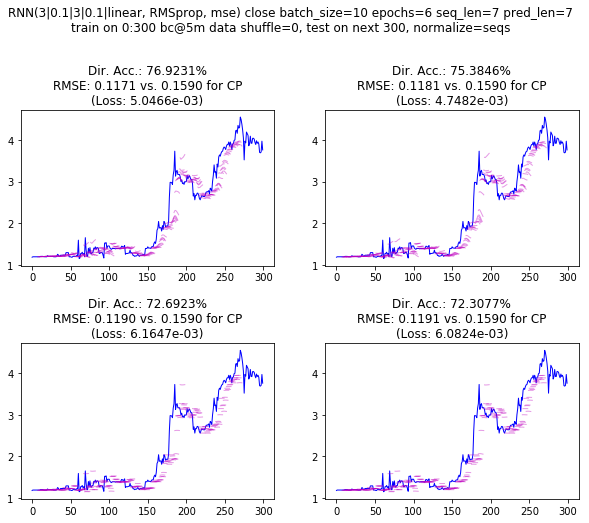

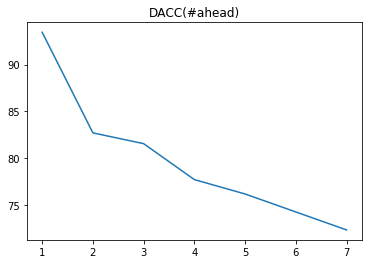

--- 174.964s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140689376004240
Tensor("lstm_275_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_275 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_275 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_276 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_276 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)       

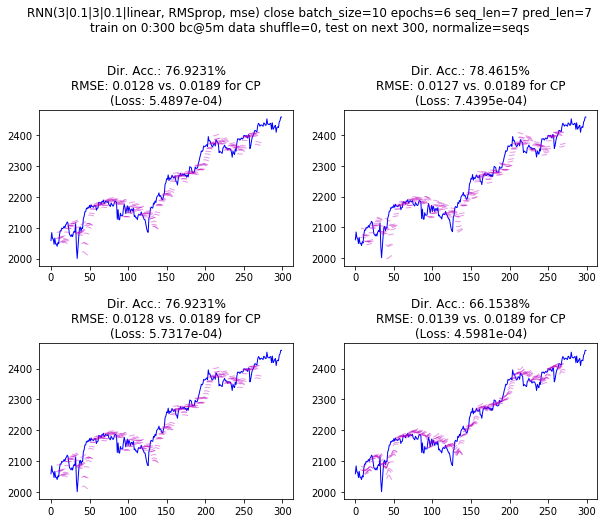

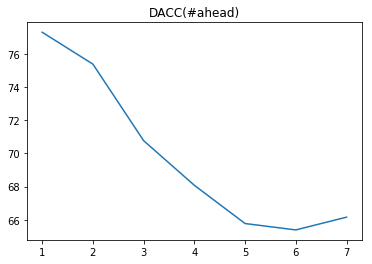

--- 165.276s to run experiment



        #################################
        # otiv
        #################################
        
data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140689287814288
Tensor("lstm_283_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_283 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_283 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_284 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_284 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_142 (Dense)            (None, 1)        

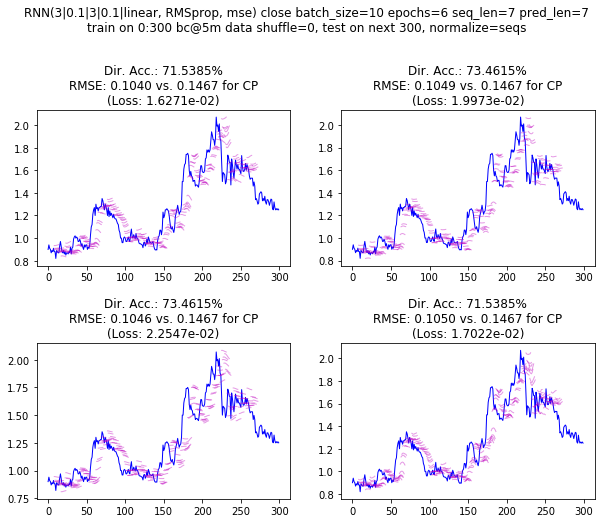

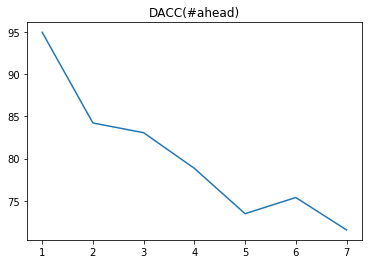

--- 168.535s to run experiment



In [33]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )

## Full runs

In [34]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 3,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [35]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [51]:
def full_run(idx_from, idx_to, data, out_filename, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(out_filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          data_df=data,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()



        #################################
        # ostk
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689152535056
Tensor("lstm_295_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_295 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_295 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_296 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_296 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_148 (Dense)     

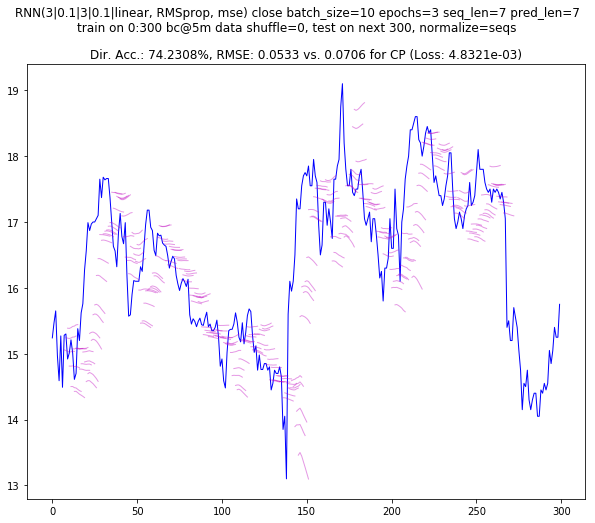

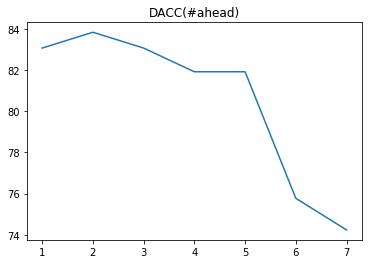

--- 49.736s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689130881296
Tensor("lstm_297_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_297 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_297 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_298 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_298 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

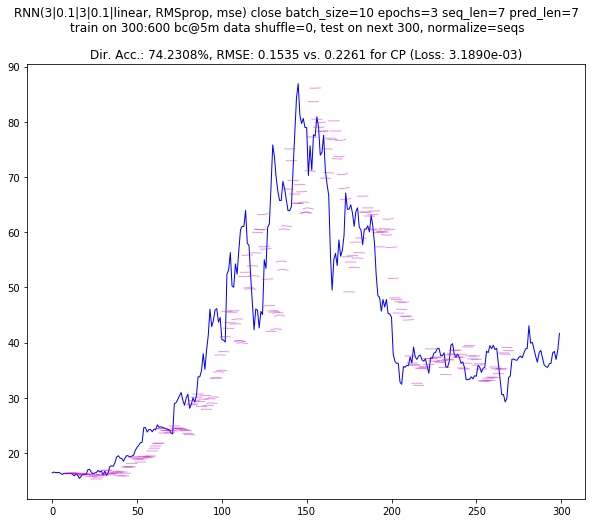

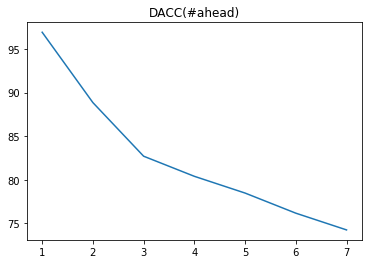

--- 42.265s to run segment

--- 92.002s to full run 300 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689130085328
Tensor("lstm_299_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_299 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_299 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_300 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_300 (Dropout)        (None, 3)                 0         
_________________________

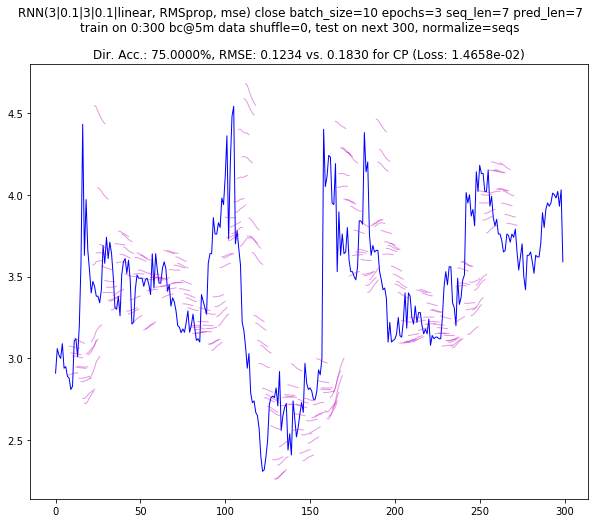

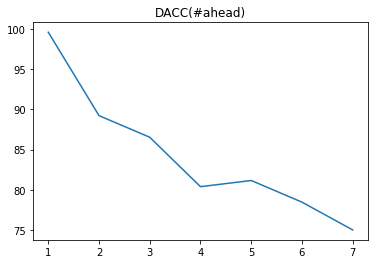

--- 42.693s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689084296208
Tensor("lstm_301_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_301 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_302 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_302 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

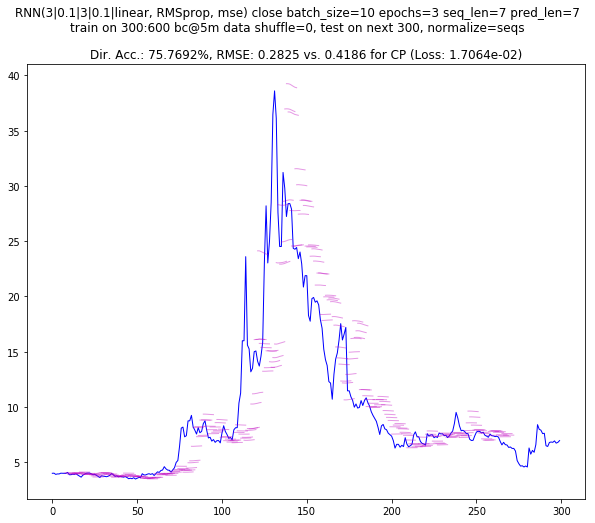

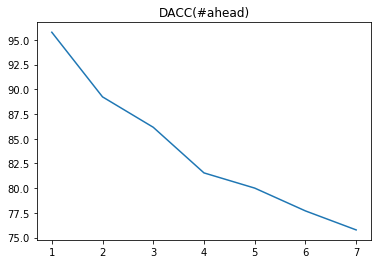

--- 42.691s to run segment

--- 85.385s to full run 300 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689061273808
Tensor("lstm_303_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_303 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_303 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_304 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_304 (Dropout)        (None, 3)                 0         
__________________________

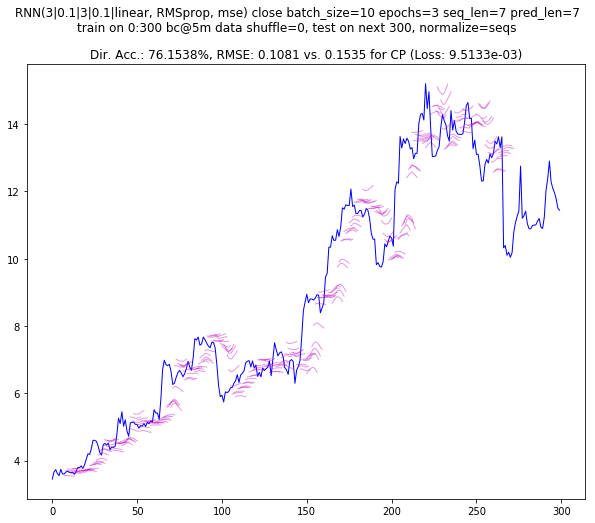

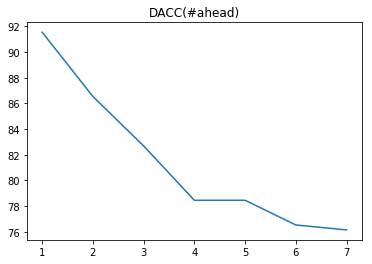

--- 44.015s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.032s to model compilation time


--- Created model id: 140689037463824
Tensor("lstm_305_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_305 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_305 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_306 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_306 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

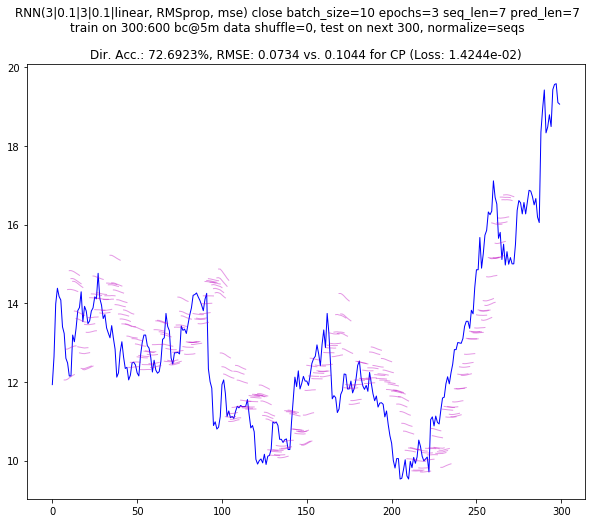

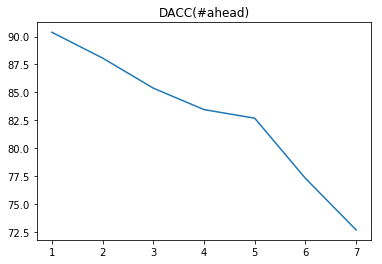

--- 44.252s to run segment

--- 88.267s to full run 300 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689016883728
Tensor("lstm_307_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_307 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_307 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_308 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_308 (Dropout)        (None, 3)                 0         
_________________________

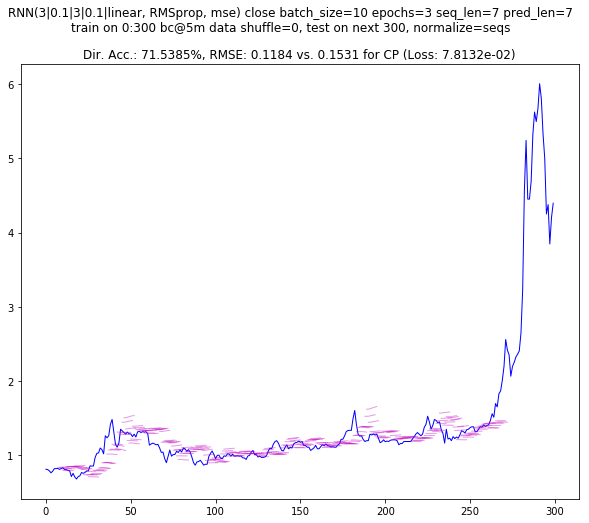

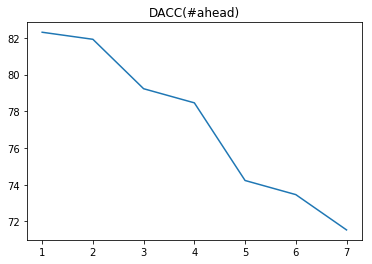

--- 44.051s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140688993864976
Tensor("lstm_309_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_309 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_309 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_310 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_310 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

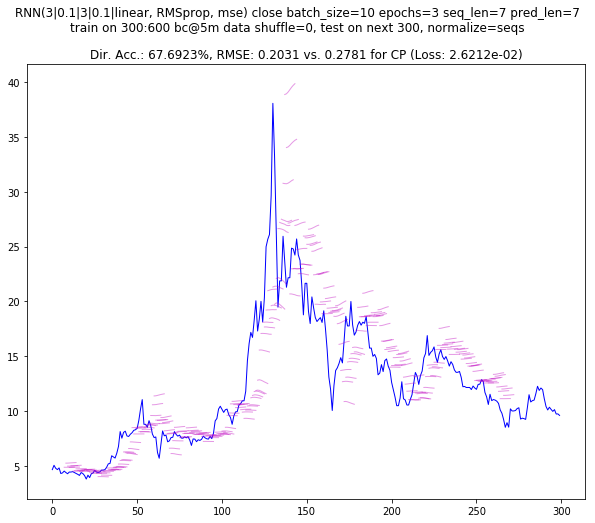

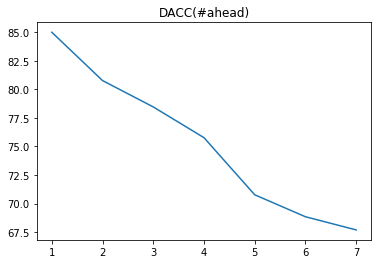

--- 44.199s to run segment

--- 88.251s to full run 300 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140688993227024
Tensor("lstm_311_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_311 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_311 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_312 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_312 (Dropout)        (None, 3)                 0         
_________________________

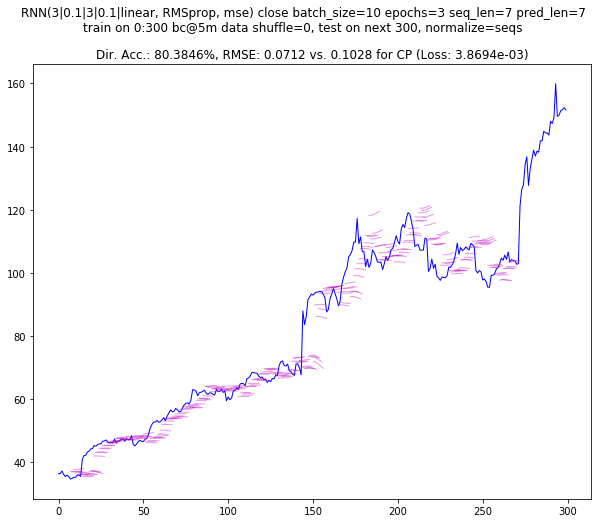

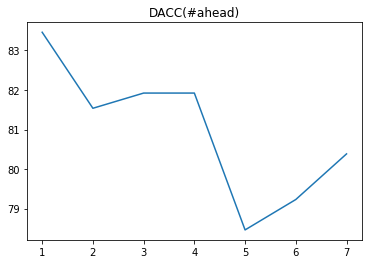

--- 44.945s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140688969930064
Tensor("lstm_313_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_313 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_313 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_314 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_314 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

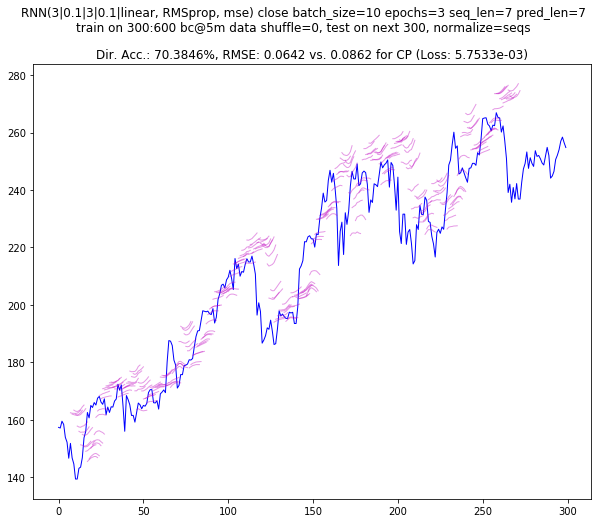

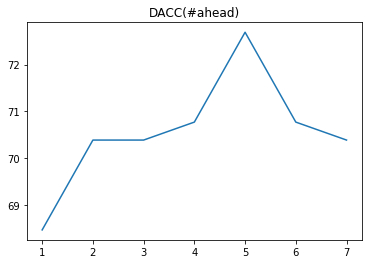

--- 44.437s to run segment

--- 89.382s to full run 300 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140688924834960
Tensor("lstm_315_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_315 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_315 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_316 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_316 (Dropout)        (None, 3)                 0         
_________________________

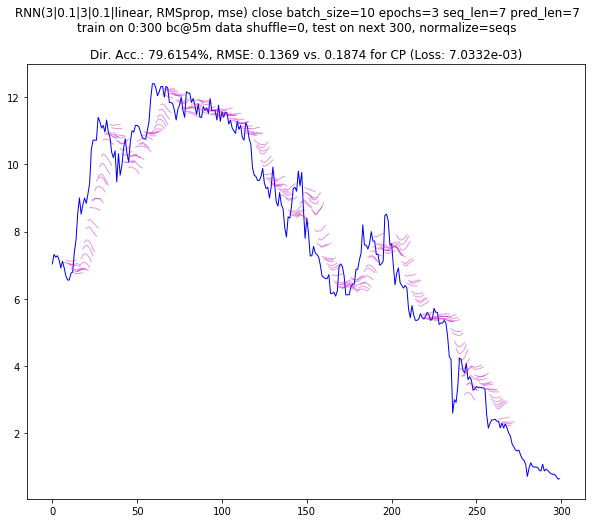

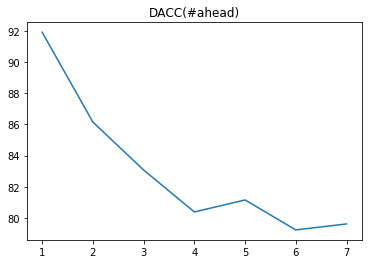

--- 44.750s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140688903394832
Tensor("lstm_317_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_317 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_317 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_318 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_318 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

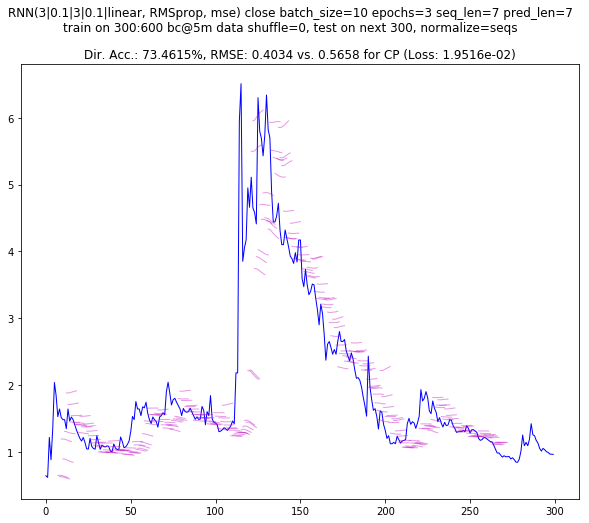

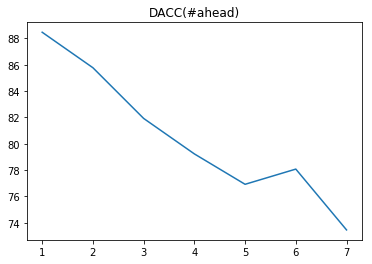

--- 177.288s to run segment

--- 222.039s to full run 300 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.034s to model compilation time


--- Created model id: 140689174698128
Tensor("lstm_319_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_319 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_319 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_320 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_320 (Dropout)        (None, 3)                 0         
_______________________

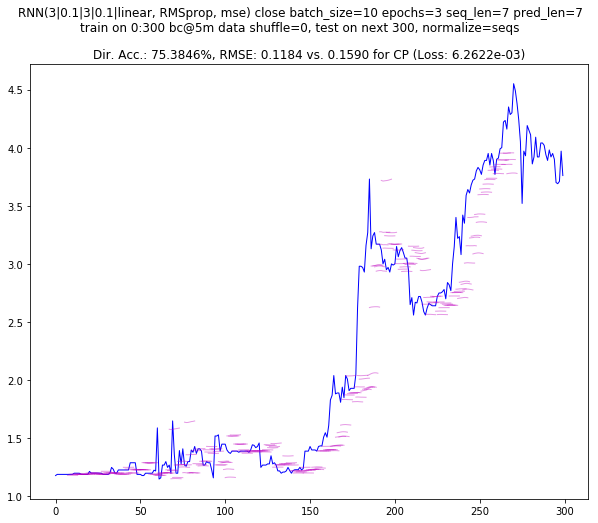

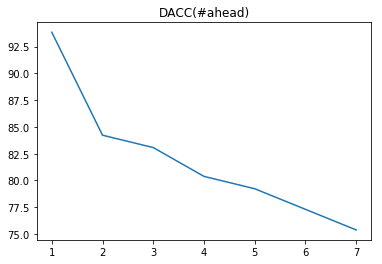

--- 49.044s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.023s to model compilation time


--- Created model id: 140689175533840
Tensor("lstm_321_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_321 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_321 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_322 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_322 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

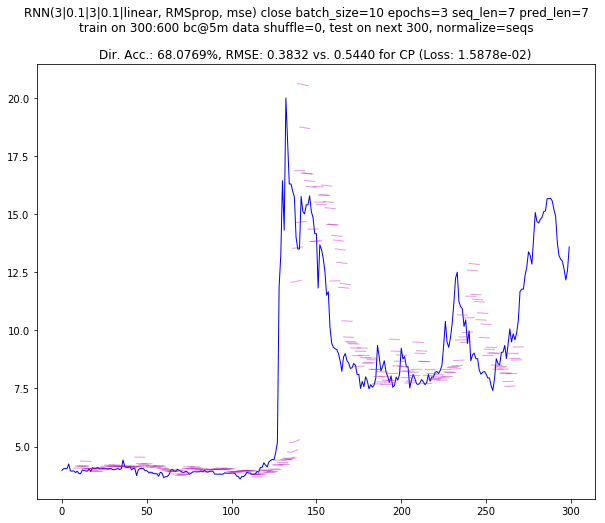

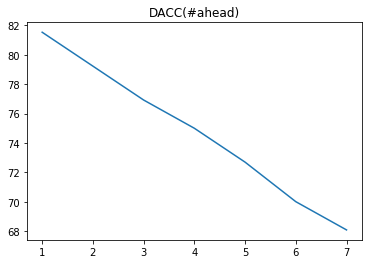

--- 47.515s to run segment

--- 96.560s to full run 300 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140689175817680
Tensor("lstm_323_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_323 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_323 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_324 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_324 (Dropout)        (None, 3)                 0         
________________________

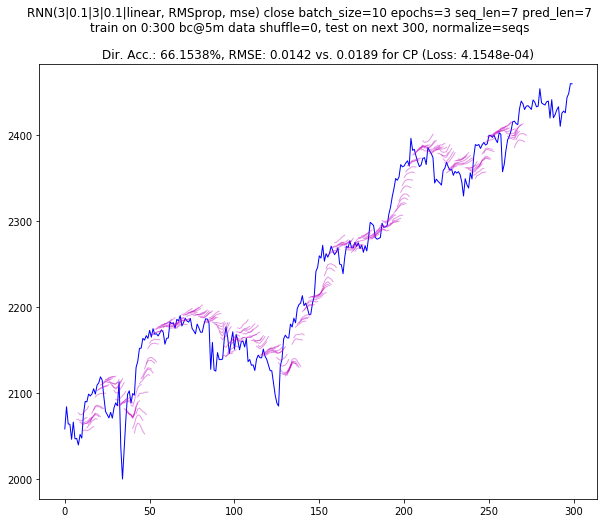

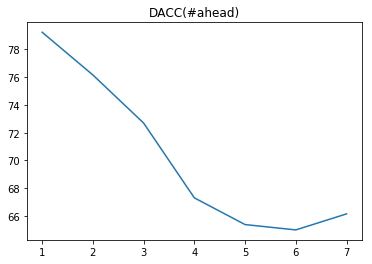

--- 47.182s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.024s to model compilation time


--- Created model id: 140689265877456
Tensor("lstm_325_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_325 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_325 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_326 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_326 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

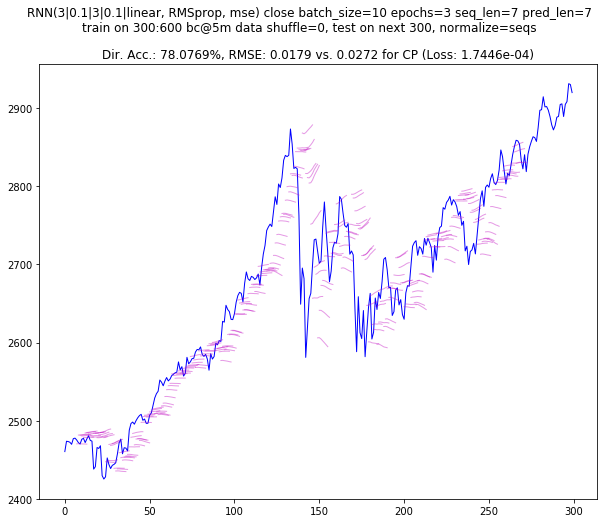

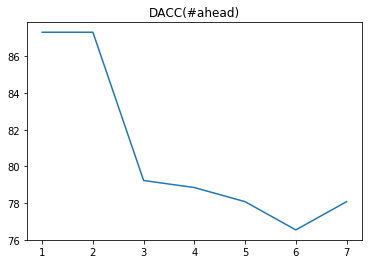

--- 47.741s to run segment

--- 94.923s to full run 300 - 614



        #################################
        # otiv
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689449371088
Tensor("lstm_327_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_327 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_327 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_328 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_328 (Dropout)        (None, 3)                 0         
_________________________

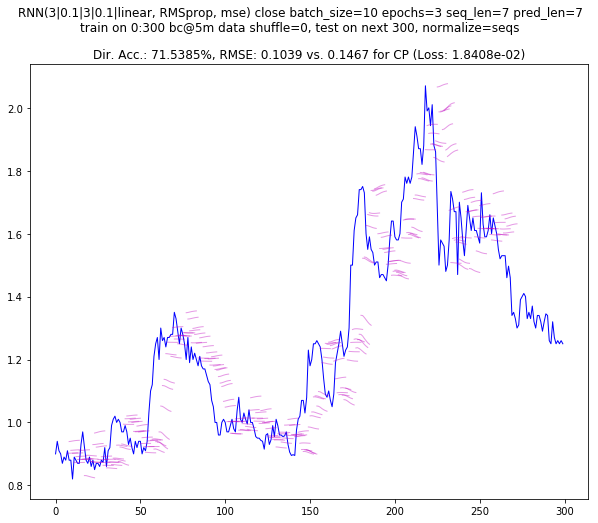

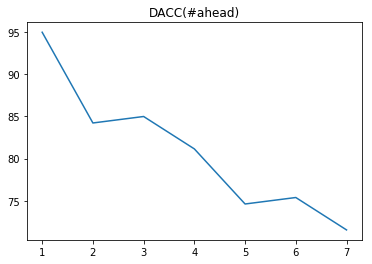

--- 47.750s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140689039517200
Tensor("lstm_329_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_329 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_329 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_330 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_330 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

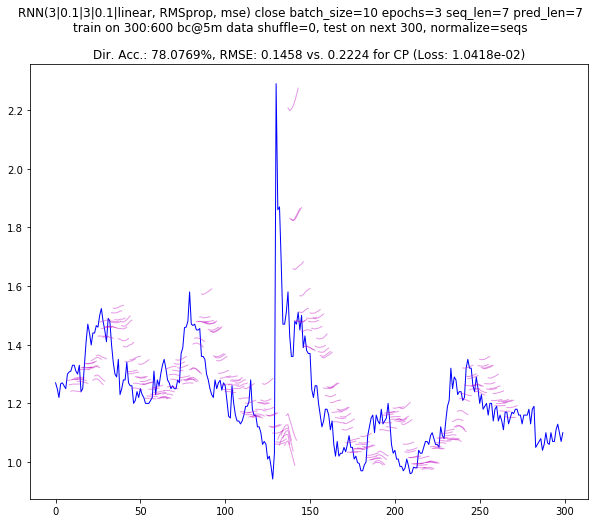

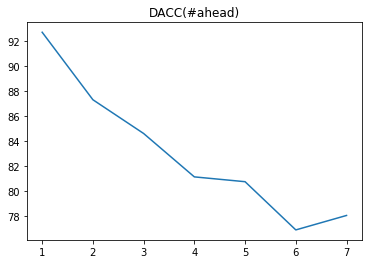

--- 48.195s to run segment

--- 95.946s to full run 300 - 645



In [52]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(300, len(data) - 300, data,
             out_filename='./results/stock_%s_c.csv' % stock,
             write_csv_header=True)

In [55]:
results = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_c.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results[stock] = r



---------
> stock SP500: RMSE=0.0161% (vs. 0.0231% for CP), DACC=72.12%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.000415  0.0142   0.0189  66.1538  
1      300    False      seqs       0.000174  0.0179   0.0272  78.0769



---------
> stock AMD: RMSE=0.0907% (vs. 0.1290% for CP), DACC=74.42%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.009513  0.1081   0.1535  76.1538  
1      300    False      seqs       0.014244  0.0734   0.1044  72.6923



---------
> stock NVDA: RMSE=0.0677% (vs. 0.0945% for CP), DACC=75.38%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.003869  0.0712   0.1028  80.3846  
1      300    False      seqs       0.005753  0.0642   0.0862  70.3846



---------
> stock GBTC: RMSE=0.1608% (vs. 0.2156% for CP), DACC=69.62%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.078132  0.1184   0.1531  71.5385  
1      300    False      seqs       0.026212  0.2031   0.2781  67.6923



---------
> stock MARA: RMSE=0.2702% (vs. 0.3766% for CP), DACC=76.54%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.007033  0.1369   0.1874  79.6154  
1      300    False      seqs       0.019516  0.4034   0.5658  73.4615



---------
> stock OSTK: RMSE=0.1034% (vs. 0.1483% for CP), DACC=74.23%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.004832  0.0533   0.0706  74.2308  
1      300    False      seqs       0.003189  0.1535   0.2261  74.2308



---------
> stock OTIV: RMSE=0.1249% (vs. 0.1845% for CP), DACC=74.81%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.018408  0.1039   0.1467  71.5385  
1      300    False      seqs       0.010418  0.1458   0.2224  78.0769



---------
> stock RIOT: RMSE=0.2029% (vs. 0.3008% for CP), DACC=75.38%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.014658  0.1234   0.1830  75.0000  
1      300    False      seqs       0.017064  0.2825   0.4186  75.7692



---------
> stock SIEB: RMSE=0.2508% (vs. 0.3515% for CP), DACC=71.73%


model_description  train_from  train_to  \
0  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       300   
1  RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.006262  0.1184    0.159  75.3846  
1      300    False      seqs       0.015878  0.3832    0.544  68.0769